# IFT608: Devoir sur l'apprentissage par renforcement

    
**Date de remise :** 

Le but de ce devoir est d'expérimenter les méthodes dites *policy gradient* et variantes, y compris les méthodes de réduction de la variance.

Les objectifs seront de compléter les implémentations d'agents RL qui apprendront une politique paramétrée en utilisant des réseaux neuronaux pour résoudre la tâche [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). La tâche CartPole consiste à apprendre à un agent comment équilibrer un poteau sur le chariot sans tomber pendant un temps maximum.

Vous analyserez également le comportement de votre agent sur différentes méthodes qui définissent sa politique à l'aide de graphiques des récompenses obtenues.

![Cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

[Vous pouvez trouver plus de detail sur cet environement ici](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

## Rappel
Rappelez vous du théorème policy gradient suivant:

&emsp;&emsp;$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta}\left[ \nabla_\theta ln\pi_\theta (a|s)Q^{\pi_θ}(s,a)\right]$ \\

Par Monte Carlo (à partir de l’expérience), $J(\theta)$ peut être estimé de la manière suivante:

&emsp;&emsp;$J(\theta) = \frac{1}{\sum T_i}\sum_{j=1}^{|D|} \sum_{t=1}^{T_j}Q^{\pi_θ}(a_t^j|s_t^j)ln\pi_\theta (a_t^j|s_t^j)$ \\

Avec

* $D$, l'ensemble de trajectoires collectées en utilisant la politique ${\pi_θ}$;
* $τ^i = (s_0^i, a_0^i, r_0^i, s_1^i,...,s_{T_i}^i, a_{T_i}^i, r_{T_i}^i)$ la ième trajectoire.

Note: Il est important de savoir que la formule de $J(\theta)$ peut légèrement différer de ce qu'on a vu au cours, pour la simple raison qu'ici on considère un batch d'expériences avant de mettre à jour les paramètres au lieu d'utiliser un seul épisode. C'est pour des raisons de stabilité de l’entraînement des modèles et cela fait partie de bonnes pratiques.

Pour chaque variant de l'algorithme, nous allons voir comment choisir le terme $Q^{\pi_θ}$. 

La règle pour mettre à jour les paramètres $θ$ est la suivante:

  &emsp;&emsp;$\theta_i = \theta_i + \alpha \nabla_\theta J(\theta)$

  avec $\alpha$ le pas d'apprentissage (learning rate ou step size).

## Préparation de l'environement.

In [ ]:
# install dependecies
%%capture
!pip install "gymnasium[all]"
!pip install pyvirtualdisplay

!sudo apt-get install xvfb

### Importation de librairies.

In [ ]:
# Run this cell

# type hinting 
from typing import Sequence, Tuple, Dict, Any, Optional

import numpy as np
import random

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# env
import gymnasium as gym
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

# data manipulation, colab dispaly, and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# misc util
import random, glob, base64, itertools
from pathlib import Path
from pprint import pprint

/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [ ]:
%matplotlib inline

## Fonctions utilitaires

### Fonction pour visualiser l'environnement dans colab

In [ ]:
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start(); 

### Classe chargée de créer les instances des models de réseaux neuronaux de l'agent.

In [ ]:
# Classe pour construire un modèle
class Model(nn.Module):
    def __init__(self, features: Sequence[int], fn=nn.ReLU):
        """Fully-connected Network

        Args:
            features: a list of ints like: [input_dim, 16, 16, output_dim]
        """
        super(Model, self).__init__()
        
        layers = []
        for i in range(len(features) - 1):
            layers.append(
                nn.Linear(
                    in_features=features[i],
                    out_features=features[i + 1],
                    )
            )
            if i != len(features) - 2:
                layers.append(fn())
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, input):
        return self.net(input)

### Classe de base d'un agent.

Vous allez implémenter la méthode `optimize_model` pour chacun de type d'agent.

In [ ]:
# Classe pour un agent de base
class BaseAgent(object):
    """ The base agent class function.
    """
    
    def __init__(self, config: Dict[str, Any]):
        """
        args:
            config: configuration dictionary
        """
        self.config = config

        # environment
        self.seed = config['seed']
        self.env = gym.make(**config['env_id'])

        self.env_monitor = gym.make(**config['env_id_monitor'])

        self.gamma = config['gamma']

        # set seed
        np.random.seed(seed=config['seed'])
        random.seed(config['seed'])
        torch.manual_seed(config['seed'])

        # build policy model
        _policy_logits_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n], fn=config['policy_activation']
        )
        # NOTE: by design, policy model should take *batches* of states as input.
        # self.policy_model spits out the probability of each action
        self.policy_model = nn.Sequential(
            _policy_logits_model, nn.Softmax(dim=1), 
        )
        self.policy_optimizer = torch.optim.Adam(
            self.policy_model.parameters(), 
            lr=config['policy_learning_rate'],
        )
        

        if config['use_baseline']:
            self.value_model = Model(
              [self.env.observation_space.shape[0]] + 
              self.config['value_layers'] + [1], fn=config['value_activation']
            )
            self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=config['value_learning_rate'])
    
    def _make_returns(self, rewards: np.ndarray):
        """ Compute the cumulative discounted rewards at each time step

        args:
            rewards: an array of step rewards

        returns:
            returns: an array of discounted returns from that timestep onward
        """
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    # Method to implement
    def optimize_model(self, n_episodes: int) -> np.ndarray:
        """ Takes a gradient step on policy (and value) parameters using 
            `n_episodes` number of episodes. You'll need to implement
            this method for each part of this problem: namely, gather a 
            dataset of size `n_episodes`, approximate the gradient using 
            REINFORCE, and apply it to the model parameters. 

        args:
            n_episodes: number of trajectories in dataset

        returns:
            returns: the total discounted reward of each trajectory/episode.
        """
        
        raise NotImplementedError
    
    def train(self, n_episodes: int, n_iterations: int, plot: bool = True) -> Sequence[np.ndarray]:
        """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """
        
        rewards = []
        for it in range(n_iterations):
            rewards.append(self.optimize_model(n_episodes))
            print(f'Iteration {it + 1}/{n_iterations}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')

        if plot:
            self.plot_rewards(rewards)

        return(rewards)
        
    @staticmethod
    def plot_rewards(rewards: Sequence[np.ndarray], ax: Optional[Any] = None):
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        if ax is None:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        else:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);
        
    def evaluate(self):
        """ Evaluate and visualize a single episode.
        """

        env = gym.make(**config['env_id_monitor'])
        self.monitor_env = VideoRecorder(env, "./gym-results.mp4") #, force=True, video_callable=lambda episode: True)
        observation, _ = self.monitor_env.env.reset(seed=self.seed)
        observation = torch.tensor(observation, dtype=torch.float)[None, :]
        reward_episode = 0
        done = False
        self.policy_model.eval()
        with torch.no_grad():    
          while not done:
              self.monitor_env.capture_frame()
              probs = self.policy_model.forward(observation)
              action = torch.multinomial(probs, 1)[0] # draw samples from dist
              observation, reward, terminated, truncated, info = self.monitor_env.env.step(int(action))
              done = terminated or truncated
              observation = torch.tensor(observation, dtype=torch.float)[None, :]
              reward_episode += reward

        self.policy_model.train()
        self.monitor_env.close()
        show_video("./")
        print(f'Reward: {reward_episode}')
        

# Question 2. REINFORCE

REINFORCE est un algorithme policy gradient où les returns échantillonnés $G_t$ sont utilisés comme estimations non biaisées de $Q^{π_θ} (s, a)$. L'estimateur de REINFORCE peut être exprimé comme le gradient de la fonction objectif suivante :

&emsp;&emsp;$J(\theta) = \frac{1}{\sum T_i}\sum_{j=1}^{|D|} \sum_{t=1}^{T_j}G_t^jln\pi_\theta (a_t^j|s_t^j)$ \\

Avec 

$G_t^j=\sum_{k = 0}^{T_j} \gamma^{k} R_{t+k+1}^j$

Implémentation de  `optimize_model`. Cette méthode est appelée à chaque itération de l’entraînement et est chargée de :

1. collecter un ensemble de données d'épisodes
2. calculer l'espérance du gradient de la politique.
>Notez que vous ne calculerez que la valeur de la perte (loss value).

*ASTUCE* :

* Notez que le modèle de réseau de neurones pour la politique `self.policy_model` produit la probabilité de prendre chaque action discrète. Par conséquent, vous devez échantillonner à partir de cette distribution. Jetez un coup d'oeil à la méthode `self.evaluate()` dans la classe `BaseAgent`.

* Gardez à l'esprit que le réseau de neurones de politiques prend un batch d'états comme entrée, par opposition à un état unique. C'est par conception, et c'est une pratique bonne et commune, cependant, vous devez garder un œil sur les dimensions d'entrée/sortie.

* Vous avez probablement besoin d'appeler la méthode `BaseAgent._make_returns` pour obtenir le return.

#### code source

In [ ]:

# Insert your code and run this cell
class REINFORCEv1Agent(BaseAgent):
    """ REINFORCE agent.
    """
    
    def optimize_model(self, n_episodes: int):
        """  
        """

        # ======================================================================

        # INSÉREZ VOTRE CODE ICI !
        total_rewards = []
        sum_ti_length = 0
        loss = 0


        for ep in range(n_episodes):

          log_probs = []
          rewards = []
          states = []
          actions = []          

          observation, _ = self.env.reset(seed=self.seed)
          # print(observation)
          observation = torch.tensor(observation, dtype=torch.float)[None, :]
          done = False
              
          while not done:
              probs = self.policy_model.forward(observation)
              action = torch.multinomial(probs, 1)[0] # draw samples from dist

              log_probs.append(probs[0][action])
              
              observation, reward, terminated, truncated, info = self.env.step(int(action))
              done = terminated or truncated

        
              observation = torch.tensor(observation, dtype=torch.float)[None, :]

              rewards.append(reward)

              
              sum_ti_length += 1


          d_rewards = self._make_returns(rewards)
          total_rewards.append(d_rewards[0])
          
          d_rewards = torch.tensor(d_rewards, dtype=torch.float)[:, None]

          loss += torch.sum(-d_rewards * torch.log(torch.stack(log_probs)))
          
        
        total_rewards = np.array(total_rewards)
        loss /= sum_ti_length
        
        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        return total_rewards

Iteration 1/100: rewards 19.6 +/- 7.6
Iteration 2/100: rewards 24.66 +/- 15.75
Iteration 3/100: rewards 24.76 +/- 12.94
Iteration 4/100: rewards 25.78 +/- 12.48
Iteration 5/100: rewards 25.72 +/- 17.49
Iteration 6/100: rewards 29.22 +/- 18.09
Iteration 7/100: rewards 26.38 +/- 12.72
Iteration 8/100: rewards 28.14 +/- 13.78
Iteration 9/100: rewards 32.66 +/- 19.52
Iteration 10/100: rewards 37.16 +/- 20.81
Iteration 11/100: rewards 42.2 +/- 22.84
Iteration 12/100: rewards 43.8 +/- 18.63
Iteration 13/100: rewards 49.12 +/- 22.14
Iteration 14/100: rewards 55.44 +/- 23.17
Iteration 15/100: rewards 67.08 +/- 29.38
Iteration 16/100: rewards 64.58 +/- 20.08
Iteration 17/100: rewards 66.98 +/- 20.54
Iteration 18/100: rewards 68.36 +/- 20.84
Iteration 19/100: rewards 71.66 +/- 22.18
Iteration 20/100: rewards 83.82 +/- 29.47
Iteration 21/100: rewards 85.32 +/- 31.25
Iteration 22/100: rewards 84.78 +/- 24.04
Iteration 23/100: rewards 86.48 +/- 26.61
Iteration 24/100: rewards 91.12 +/- 25.82
Iterat

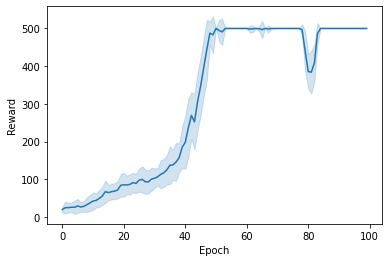

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
# Voici un exemple de configuration adaptée à la question ci-dessus. Gardez la même configuration.
config = {
    'env_id': dict(id="CartPole-v1"),
    'env_id_monitor': dict(id="CartPole-v1", render_mode="rgb_array_list", disable_env_checker=True),
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 32],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
    'policy_activation':nn.ReLU
}
agent = REINFORCEv1Agent(config)
REINFORCEv1_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
agent.evaluate()

Moviepy - Building video ./gym-results.mp4.
Moviepy - Writing video ./gym-results.mp4



Moviepy - Done !
Moviepy - video ready ./gym-results.mp4


Reward: 500.0


### Q 1.1. Énumérez les elements de différence qui existent entre les algorithmes REINFORCE et DQN **[10 points]**.

# Question 2. REINFORCE avec baseline

REINFORCE est réputé d'avoir une variance assez grande qui peut causer d'instabilité lors de l'apprentissage. L'utilisation d'une baseline permet de reduire sa variance. Dans cette version de l'agent, nous allons considérer $\left(G_t - B(s_t) \right)$ comme estimations non biaisées de $Q^{π_θ} (s, a)$. L'estimateur de REINFORCE peut être exprimé comme le gradient de la fonction objectif suivante :

&emsp;&emsp;$J(\theta) = \frac{1}{\sum T_i}\sum_{j=1}^{|D|} \sum_{t=1}^{T_j}\left(G_t^j - B(s_t^j)\right)ln\pi_\theta (a_t^j|s_t^j)$ \\

Avec 

$G_t^j=\sum_{k = 0}^{T_j} \gamma^{k} R_{t+k+1}^j$ et  $B(s_t)=V(s_t)$, la baseline qui est un estimateur de la valuer de l'état (utilité d'un état) à l'intant t dans la trajectoire.

Notez que $B_\phi(s_t)$ est un réseau de neurones qui estime la valeur d'un état. Il est paramétré par $\phi$. 

Implémentation de  `optimize_model`. Cette méthode est appelée à chaque itération de l’entraînement et est chargée de :

1. collecter un ensemble de données d'épisodes
2. calculer l'espérance du gradient de la politique.
>Notez que vous ne calculerez que la valeur de la perte (loss value).
3. En plus ici, vous devrez calculer la perte de la fonction d'utilité des états et appeler `auto-diff` sur cette perte pour mettre à jour les paramètres du réseau d'utilité-état.
&emsp;&emsp;$L_V(\phi) = \frac{1}{\sum T_i}\sum_{j=1}^{|D|} \sum_{t=1}^{T_j}\left(G_t^j - B(s_t^j)\right)^2$ \\

> Ici, vous avez accès et devez utiliser `self.value_model` et `self.value_optimizer` et `self.value_optimizer`, et vous devez former une perte pour mettre à jour la fonction d'utilité-état. 

*ASTUCE* :

* Vous devez utiliser la fonction `.detach()` de torch pour stoper le re-flow du gradients.

#### code source:

In [ ]:
# Insert your code and run this cell
class REINFORCEv2PlusBaselineAgent(BaseAgent):
    """ Baseline Agent: 
        Here we try to reduce the variance by introducing a baseline, which is 
        the value function in this case.
    """
    
    def optimize_model(self, n_episodes: int):
        """ VOUS DEVEZ IMPLÉMENTER CETTE MÉTHODE 
        """
        # ======================================================================

          # INSEREZ VOTRE CODE ICI !
        total_rewards = []
        sum_ti_length = 0
        policy_loss = 0
        value_loss = 0


        for ep in range(n_episodes):

          log_probs = []
          rewards = []
          states = []
          actions = []          

          observation, _ = self.env.reset(seed=self.seed)
          observation = torch.tensor(observation, dtype=torch.float)[None, :]
          states.append(observation)

          reward_episode = 0
          done = False
              
          while not done:
              probs = self.policy_model.forward(observation)
              action = torch.multinomial(probs, 1)[0] # draw samples from dist

              log_probs.append(probs[0][action])

              observation, reward, terminated, truncated, info = self.env.step(int(action))
              observation = torch.tensor(observation, dtype=torch.float)[None, :]
              done = terminated or truncated
            
              states.append(observation)

              reward_episode += reward

              rewards.append(reward)
              sum_ti_length += 1

          d_rewards = self._make_returns(rewards)
          total_rewards.append(d_rewards[0])
          
          d_rewards = torch.tensor(d_rewards, dtype=torch.float)[:, None]
          states = torch.stack(states[:-1]) 

          
          states_values = self.value_model(states.squeeze(1))

          value_loss += torch.sum((d_rewards - states_values) ** 2)

          advantages = d_rewards - states_values.detach()

          

          log_probs = torch.log(torch.stack(log_probs))

          policy_loss += torch.sum(- advantages * log_probs)
          
        
        total_rewards = np.array(total_rewards)
        policy_loss /= sum_ti_length
        value_loss /= sum_ti_length
        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # additionally we update the value network parameters
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return total_rewards
   

#### Exécution

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
# Voici un exemple de configuration adaptée à la question ci-dessus. Gardez la même configuration.

config = {
    'env_id': dict(id="CartPole-v1"),
    'env_id_monitor': dict(id="CartPole-v1", render_mode="rgb_array_list", disable_env_checker=True),
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 32],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 32, 8],
    'value_learning_rate': 5e-3,
    'policy_activation':nn.ReLU,
    'value_activation':nn.ReLU,
}
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards = agent.train(n_episodes=50, n_iterations=100)
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
agent.evaluate()

Moviepy - Building video ./gym-results.mp4.
Moviepy - Writing video ./gym-results.mp4



Moviepy - Done !
Moviepy - video ready ./gym-results.mp4


Reward: 500.0


### Question 2.1. 

La cellule ci-dessous affiche sur un même graphique les récompenses pour les deux types d'agents : `REINFORCE` et `REINFORCE+B`. Veuillez commenter l'effet de l'introduction d'une baseline sur la variance de récompenses. Observez-vous autre chose sur les récompenses, au delà de la variance? **[20 points]**

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
#plt.rcParams['figure.figsize'] = [10, 10]
plt.legend(labels=['REINFORCEv1', 'REINFORCEPlusBaselineAgent'])

### Question 2.2. 

Vous allez maintenant afficher sur un même graphique et comparer le comportement de l'agent `REINFORCE+B` avec différentes valeur d'escompte
$\gamma \in \{0.975, 0.99, 0.995, 1\}$.
Veuillez rapporter vos observations sur le résultat et expliquer pourquoi certaines valeurs d'escompte ne sont pas appropriées. **[20 points]**

#### code

In [ ]:
#===============================================================================
# INSEREZ VOTRE CODE ICI



#===============================================================================

# Q3. Actor-Critic Agent
 

Implémentation d'un agent `one-step Actor-Critic` ci-dessous avec le calcul de gradient de la politique suivant.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_{t:t+1}^j - V(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
avec $G_{t:t+1}^j= R_t + \gamma V(s_{t+1}^j)$ est la récompense cumulée tronquée calculé à partir de l'état actuel, $s_t^j$ pour l'épisode $j$. \\




Le réseau critique doit être un estimateur de la fonction d'utilité des état.

### Qn 3.1 : Bien que l'agent précédent `REINFORCEv2+B` ait utilisé un réseau d'estimateurs de valeur d'utilité des états similaire à celui de l'agent Actor-Critic, pourquoi n'est-il pas appelé une méthode Actor-Critic ? **[20 points]**

In [ ]:
class ActorCriticAgent(BaseAgent):
    """ A2C Agent: Actor-Critic
        Here we try to FURTHER reduce the variance via bootstrapping.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value
            In addition implement the critic network
            HINT:
                * If you've made it this far you don't need another hint!
        """
        # ======================================================================

          # YOUR CODE HERE !

        total_rewards = []
        policy_loss = 0
        value_loss = 0
        sum_ti_length = 0

        huber_loss = torch.nn.HuberLoss(reduction='sum')

        for ep in range(n_episodes):

          log_probs = []
          rewards = []
          states = []
          actions = []          

          observation, _ = self.env.reset(seed=self.seed)
          observation = torch.tensor(observation, dtype=torch.float)[None, :]
          states.append(observation)

          reward_episode = 0
          done = False
              
          while not done:
              probs = self.policy_model.forward(observation)
              action = torch.multinomial(probs, 1)[0] # draw samples from dist

              log_probs.append(probs[0][action])

              observation, reward, terminated, truncated, info = self.env.step(int(action))
              observation = torch.tensor(observation, dtype=torch.float)[None, :]
              done = terminated or truncated
            
              states.append(observation)

              reward_episode += reward

              rewards.append(reward)
              sum_ti_length += 1

          d_rewards = self._make_returns(rewards)
          total_rewards.append(d_rewards[0])
          d_rewards = torch.tensor(d_rewards, dtype=torch.float)[:, None]
          
          states = torch.stack(states[:-1])  
          
          

          states_values = self.value_model(states.squeeze(1))
          states_values_prime = torch.cat([states_values[1:],
                                    torch.tensor([[0]], dtype=torch.float)])
          
          states_values_prime *= self.gamma
        
          
          rewards = torch.tensor(rewards, dtype=torch.float)
          

          delta = rewards.unsqueeze(-1) + states_values_prime.detach() - states_values.detach()
          value_loss += torch.mean((states_values - (rewards.unsqueeze(-1) + states_values_prime)) ** 2)  
          
          log_probs = torch.log(torch.stack(log_probs))

          policy_loss += - torch.sum(delta * log_probs)
          
          
        
        total_rewards = np.array(total_rewards)
        policy_loss /= sum_ti_length
        value_loss /= sum_ti_length

        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return total_rewards
   

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
# Voici un exemple de configuration adaptée à la question ci-dessus. Gardez la même configuration.

config = {
    'env_id': dict(id="CartPole-v1"),
    'env_id_monitor': dict(id="CartPole-v1", render_mode="rgb_array_list", disable_env_checker=True),
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-1,
    'policy_activation':nn.ReLU,
    'value_activation':nn.ReLU,
}

agent = ActorCriticAgent(config)
ActorCritic_sum_rewards = agent.train(n_episodes=64, n_iterations=100)

In [ ]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
agent.evaluate()

### Q3.2. Affichez sur un même graphique les récompenses des trois agents(REINFORCE, REINFORCE+B et Actor-Critic) et commentez le résultat. **[15 points]**

In [ ]:
# insérez votre code ici
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.




### Q3.3 Faites la recherche de meilleurs hyper-paramètres de l'agent Actor-Critic, ensuite entraînez l'agent avec les paramètres trouvés **[15 points]**.  

In [ ]:
# insérez votre code ici
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
